In [2]:
import sys
import subprocess

# Liste der benötigten Pakete
pakete = ["numpy", "pandas", "matplotlib", "socceraction" , "warnings","json"]  # Hier deine Pakete eintragen

# Installiere Pakete, falls sie nicht vorhanden sind
for paket in pakete:
    try:
        __import__(paket)
    except ImportError:
        print(f"{paket} wird installiert...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", paket])

In [1]:
import pandas as pd
import os
import json
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, brier_score_loss
import socceraction.spadl as spadl
import numpy as np

In [3]:
# Import functions
from src.data_processing import config_h5_file_paths, fetch_match_data, generate_match_data, split_games, split_match_data, adjust_results, load_match_data

In [ ]:
# Configure format, h5-file, and folder names
datafolder = ".\\xSuccess\\top5_15-16_spadl"
format = "spadl"

match_data_h5, match_data_train_h5, match_data_test_h5, match_data_test_success_h5, match_data_test_fail_h5, features_train_h5, features_test_h5, features_test_success_h5, features_test_fail_h5, labels_train_h5, labels_test_h5, labels_test_success_h5, labels_test_fail_h5, predictions_test_h5, predictions_test_success_h5, predictions_test_fail_h5, vaep_test_h5, vaep_test_success_h5, vaep_test_fail_h5 = config_h5_file_paths(
  datafolder=datafolder,
  format=format
)

In [4]:
# 1. Lade den Datensatz
spadl_h5 = ".\\xSuccess\\top5_15-16_spadl\\match_data.h5"

with pd.HDFStore(spadl_h5) as spadlstore:
    # Spiele laden
    games = spadlstore["games"]
    
    # Du kannst auch teams / players laden, wenn du sie für später brauchst
    teams = spadlstore["teams"]
    players = spadlstore["players"]
    
    all_actions_list = []
    
    # Über alle Spiele iterieren
    for gid in games.game_id:
        df_actions = spadlstore[f"actions/game_{gid}"]
        # Ggf. noch die 'game_id' explizit als Spalte hinzufügen,
        # falls du sie später brauchst.
        df_actions["game_id"] = gid
        
        all_actions_list.append(df_actions)
    
    # Zu einem großen DataFrame zusammenfügen
    all_actions = pd.concat(all_actions_list, ignore_index=True)

all_actions["game_id"].count()

3639857

In [5]:
all_actions = (
    all_actions
    .merge(spadl.actiontypes_df(), how='left', on='type_id')
    .merge(spadl.results_df(), how='left', on='result_id')
    .merge(spadl.bodyparts_df(), how='left', on='bodypart_id')
)

In [6]:
# 3) Die Länge der Dribblings bestimmen (euklidische Distanz zwischen Start- und Endkoordinate)

all_actions["action_distance"] = np.sqrt(
    (all_actions["end_x"] - all_actions["start_x"])**2 +
    (all_actions["end_y"] - all_actions["start_y"])**2
)

Winkel hinzufügen

In [7]:
# Angenommen: Spielfeld geht von x=0 bis x=105 (Opta Standard)
def detect_goal_side(end_x, field_length=105):
    return 'left' if end_x < field_length / 2 else 'right'

def calculate_centered_shot_angle(row):
    # Ziel-Torposition
    if row['goal_side'] == 'right':
        goal_x, goal_y = 105, 34
        dx = goal_x - row['start_x']
    else:
        goal_x, goal_y = 0, 34
        dx = row['start_x'] - goal_x  # Richtung umdrehen!

    dy = goal_y - row['start_y']

    # Jetzt ist dx immer positiv → Richtung zum Tor ist einheitlich
    angle_rad = np.arctan2(dy, dx)
    angle_deg = np.degrees(angle_rad)

    return angle_deg

In [8]:
all_actions['shot_angle_centered'] = np.nan

In [9]:
# Torseite erkennen (für alle Zeilen, nicht nur Schüsse)
all_actions['goal_side'] = all_actions['start_x'].apply(detect_goal_side)

In [12]:
all_actions

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,action_distance,shot_angle_centered,goal_side
0,3890561,644e16d7-10ca-45f0-8128-fc0055d6f753,1,0.482,175,8387.0,52.9375,34.340,52.2375,36.210,0,1,4,0,pass,success,foot_left,1.996722,NaN,right
1,3890561,329a1879-2521-4614-8c68-b4798b0e5d23,1,0.935,175,5460.0,52.2375,36.210,51.5375,35.870,21,1,0,1,dribble,success,foot,0.778203,NaN,left
2,3890561,77e2ddaf-6de3-49e7-a318-7d765799b543,1,1.015,175,5460.0,51.5375,35.870,46.7250,32.640,0,1,4,2,pass,success,foot_left,5.795952,NaN,left
3,3890561,1b91a029-f722-4b0d-b9d5-53cdc776f9e3,1,2.167,175,6039.0,46.7250,32.640,45.3250,30.005,21,1,0,3,dribble,success,foot,2.983827,NaN,left
4,3890561,2c51f271-c812-45af-896b-06f49a14a5bb,1,2.954,175,6039.0,45.3250,30.005,29.5750,15.725,0,1,5,4,pass,success,foot_right,21.259842,NaN,left
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3639852,3878540,71006080-9dd2-401c-b02f-d8f8947644c5,2,2928.521,236,5589.0,45.0625,4.675,91.9625,34.935,0,0,5,2243,pass,fail,foot_right,55.814672,NaN,left
3639853,3878540,34beca91-bdec-408c-81d3-d423e74ec518,2,2933.156,240,7174.0,92.7500,34.170,83.5625,36.125,21,1,0,2244,dribble,success,foot,9.393199,NaN,right
3639854,3878540,7c4c3eae-84c0-4da0-baa4-e87d11376565,2,2935.131,240,7174.0,83.5625,36.125,41.1250,45.305,0,0,5,2245,pass,fail,foot_right,43.419049,NaN,right
3639855,3878540,d4d557ff-725e-4cfa-afee-e14fa9e3ed4b,2,2938.221,236,7778.0,40.3375,46.070,40.3375,46.070,10,1,0,2246,interception,success,foot,0.000000,NaN,left


In [10]:
# Winkel nur für Schüsse berechnen
shot_mask = all_actions['type_name'] == 'shot'
all_actions.loc[shot_mask, 'shot_angle_centered'] = all_actions[shot_mask].apply(calculate_centered_shot_angle, axis=1)

In [11]:
all_actions["result_id"].value_counts()

result_id
1    3013209
0     611964
2       7640
4       6724
5        163
3        157
Name: count, dtype: int64

Wieso sind in result_id noch Werte höher 1 enthalten???

Wofür steht 2, 3, 4, 5???

0 == fail \
1 == sucess\
2 == offside\
3 == owngoal\
4 == yellow_card\
5 == red_card

Nur 1 == success wird behalten, der rest wird auf 0 gesetzt

In [ ]:
all_actions["result_id"] = np.where(all_actions["result_id"] == 1, 1, 0)

Es sollen nur die spiele aus train_games zum trainieren verwendet werden

In [ ]:
# Split games
train_games, test_games, validation_games = split_games(
  games=games,
  train_percentage=50,
  random_state=42,
  shuffle=True
)

In [ ]:
unique_games = train_games['game_id'].unique()

In [ ]:
# Trainings-Daten: Enthält nur Zeilen, deren game_id in unique_games ist
all_actions_train = all_actions[all_actions['game_id'].isin(unique_games)]

# Test-Daten: Enthält nur Zeilen, deren game_id NICHT in unique_games ist
all_actions_test = all_actions[~all_actions['game_id'].isin(unique_games)]

In [ ]:

# 2. Wähle die relevanten Features und die Zielvariable
features = ["start_x", "start_y", "end_x", "end_y", "bodypart_id", "type_id", "action_distance", "time_seconds"]
target = "result_id"


X_train = all_actions_train[features].astype("float32")
y_train = all_actions_train[target]

In [ ]:
X_test = all_actions_test[features].astype("float32")
y_test = all_actions_test[target]

In [ ]:
# Modellpfad
model_path = "gb_model.pkl"

# Überprüfen, ob das Modell existiert
if os.path.exists(model_path):
    print("Lade vorhandenes Modell...")
    gb_model = joblib.load(model_path)
else:
    print("Kein gespeichertes Modell gefunden. Trainiere neues Modell...")

    # Initialisiere das Modell
    gb_model = GradientBoostingClassifier(         
        random_state=42      
    )

    # Trainiere das Modell
    gb_model.fit(X_train, y_train)

    # Speichere das Modell
    joblib.dump(gb_model, model_path)
    print("Neues Modell gespeichert als:", model_path)

In [ ]:
# 6. Erstelle Vorhersagen für die Testdaten
y_pred_old = gb_model.predict(X_test)

In [ ]:
# 7. Evaluiere das Modell, z.B. durch Berechnung der Genauigkeit
accuracy = accuracy_score(y_test, y_pred_old)

# Berechne False Positive Rate (fpr), True Positive Rate (tpr) und Schwellenwerte
fpr, tpr, thresholds = roc_curve(y_test, y_pred_old)

# Berechne die AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Berechne den Brier-Score
brier_old = brier_score_loss(y_test, y_pred_old)

print("Genauigkeit:", accuracy)
print("Brier Score:", brier_old)

In [ ]:
# Plot der ROC-Kurve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, color="darkorange", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], lw=2, linestyle="--", color="navy")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()



sind die aktionen immer von links nach rechts?\
Team A und Team B in einem Spiel die Schüssen anschauen. wo starte die aktion und wo endet sie für das jeweilige team

features = start-position, eventtype, body, direction (Winkel), actions -distanz, time_seconds,

winkel herausfinden für jede aktion

fragliche features: action-geschwindigkeit, period_id, player_id,

Player_id könnte wichtig sein wenn man das modell gewichten möchte.

Spieler A vergleich mit Spieler B

Spielertyp berücksichtigen 

ABER ALLES KOMMT ERST AM ENDE

------------------------------

Kann das Modell mit dem VAEP wert verbunden werden?

Einmal mit GAM und einmal mit XGBoost durchführen

In [ ]:
param_dist = {
    'n_estimators': np.arange(100, 501, 50),  
    'learning_rate': np.linspace(0.01, 0.2, 10),  
    'max_depth': np.arange(3, 11, 2),  
    'subsample': np.linspace(0.5, 1.0, 5)
}

random_search = RandomizedSearchCV(
    gb_model,
    param_dist, 
    n_iter=10, 
    cv=2, 
    scoring='accuracy', #log-loss oder brier score
    random_state=42, 
    n_jobs=-1)
random_search.fit(X_train, y_train)

print("Beste Parameter:", random_search.best_params_)

In [ ]:
# Beste Parameter holen
best_random_params = random_search.best_params_

# Umwandlung in normale Python-Typen
best_random_params_serializable = {key: float(value) if isinstance(value, (np.float32, np.float64)) 
                            else int(value) if isinstance(value, (np.int32, np.int64)) 
                            else value 
                            for key, value in best_random_params.items()}

# In JSON speichern
with open("beste_random_parameter.json", "w") as f:
    json.dump(best_random_params_serializable, f, indent=4)

print("Beste Parameter wurden in 'beste_random_parameter.json' gespeichert.")

Parameter direkt ausprobieren

In [ ]:
import json
from sklearn.ensemble import GradientBoostingClassifier
# JSON-Datei laden
with open("beste_random_parameter.json", "r") as f:
    best_params = json.load(f)

# Modell mit geladenen Parametern initialisieren
new_gb_model = GradientBoostingClassifier(
    **best_params,  # setzt automatisch alle Werte aus dem Dictionary ein
    random_state=42  # optional zusätzlich gesetzt
    # scoring kann hinzugefuegt werden
)

# Trainiere das Modell
new_gb_model.fit(X_train, y_train)



In [ ]:
# 6. Erstelle Vorhersagen für die Testdaten
y_proba_new  = new_gb_model.predict(X_test)

In [ ]:
# 7. Evaluiere das Modell, z.B. durch Berechnung der Genauigkeit
accuracy_new = accuracy_score(y_test, y_proba_new )

# Berechne False Positive Rate (fpr), True Positive Rate (tpr) und Schwellenwerte
fpr, tpr, thresholds = roc_curve(y_test, y_proba_new )

# Berechne die AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Berechne den Brier-Score
brier_new = brier_score_loss(y_test, y_proba_new)

print("Genauigkeit:", accuracy_new)
print("Brier Score:", brier_new)

In [ ]:
model_path = "gb_model.pkl"
if os.path.exists(model_path):
    old_model = joblib.load(model_path)
    brier_old = brier_score_loss(y_test, y_pred_old)
    print(f"📦 Brier-Score des alten Modells: {brier_old:.4f}")

    if brier_new < brier_old:
        print("✅ Neues Modell ist besser. Speichere es.")
        joblib.dump(new_gb_model, model_path)
    else:
        print("❌ Altes Modell ist besser. Behalte es.")
else:
    print("📁 Kein altes Modell gefunden. Speichere das neue.")
    joblib.dump(new_gb_model, model_path)

    

GridSearch

In [ ]:
# Grid mit limitierten Hyperparametern
param_grid = {
    'n_estimators': [100, 200, 300],  # Weniger Werte als in RandomizedSearchCV
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}

# GridSearchCV initialisieren
grid_search = GridSearchCV(
    gb_model, 
    param_grid, 
    cv=2,  # Weniger Folds für schnellere Suche
    scoring='accuracy', 
    n_jobs=-1  # Paralleles Training
)

# Suche starten
grid_search.fit(X_train, y_train)

# Beste Parameter anzeigen
print("Beste Parameter:", grid_search.best_params_)


# Grid mit limitierten Hyperparametern
param_grid = {
    'n_estimators': [100, 200, 300],  # Weniger Werte als in RandomizedSearchCV
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0]
}

# GridSearchCV initialisieren
grid_search = GridSearchCV(
    gb_model, 
    param_grid, 
    cv=3,  # Weniger Folds für schnellere Suche
    scoring='accuracy', 
    n_jobs=-1  # Paralleles Training
)

# Suche starten
grid_search.fit(X_train, y_train)

# Beste Parameter anzeigen
print("Beste Parameter:", grid_search.best_params_)

Jede Kombination wird mit cv=3 getestet, also insgesamt 81 × 3 = 243 Trainingsläufe. (3×3×3×3=81 Kombinationen)

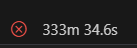

In [ ]:
# Beste Parameter speichern
grid_best_params = grid_search.best_params_

# Umwandlung in normale Python-Typen
best_params_serializable = {key: float(value) if isinstance(value, (np.float32, np.float64)) 
                            else int(value) if isinstance(value, (np.int32, np.int64)) 
                            else value 
                            for key, value in best_params.items()}

# In einer JSON-Datei speichern
with open("grid_search_params.json", "w") as f:
    json.dump(grid_best_params, f, indent=4)

print("Beste Parameter von GridSearchCV gespeichert in 'grid_search_params.json'")

In [ ]:
# Initialisiere das Modell
gb_grid_model = GradientBoostingClassifier(
    n_estimators=300,    
    learning_rate=0.1,   
    max_depth=7,         
    subsample=0.8,         
    random_state=42      
)

# Trainiere das Modell
gb_grid_model.fit(X_train, y_train)

# Speichere das Modell
#joblib.dump(gb_grid_model, model_path)
#print("Neues Modell gespeichert als:", model_path)

# 6. Erstelle Vorhersagen für die Testdaten
y_proba_new  = gb_grid_model.predict(X_test)

# 7. Evaluiere das Modell, z.B. durch Berechnung der Genauigkeit
accuracy_new = accuracy_score(y_test, y_proba_new )

# Berechne False Positive Rate (fpr), True Positive Rate (tpr) und Schwellenwerte
fpr, tpr, thresholds = roc_curve(y_test, y_proba_new )

# Berechne die AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Berechne den Brier-Score
brier_new = brier_score_loss(y_test, y_proba_new)

print("Genauigkeit:", accuracy_new)
print("Brier Score:", brier_new)

In [ ]:
# 6. Erstelle Vorhersagen für die Testdaten
y_proba_new  = gb_grid_model.predict(X_test)

# 7. Evaluiere das Modell, z.B. durch Berechnung der Genauigkeit
accuracy_new = accuracy_score(y_test, y_proba_new )

# Berechne False Positive Rate (fpr), True Positive Rate (tpr) und Schwellenwerte
fpr, tpr, thresholds = roc_curve(y_test, y_proba_new )

# Berechne die AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Berechne den Brier-Score
brier_new = brier_score_loss(y_test, y_proba_new)

print("Genauigkeit:", accuracy_new)
print("Brier Score:", brier_new)

In [ ]:
importances = gb_model.feature_importances_
features_sorted = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)

# Visualisieren
plt.figure(figsize=(10, 6))
plt.barh([f[0] for f in features_sorted], [f[1] for f in features_sorted])
plt.xlabel("Wichtigkeit")
plt.title("Feature Importance im Modell")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()